# **Background**
Transcription factors are proteins that bind DNA at promoters to drive gene expression. Most preferentially bind to specific sequences while ignoring others. Traditional methods to determine these sequences (called motifs) have assumed that binding sites in the genome are all independent. However, in some cases people have identified motifs where positional interdependencies exist.

# **Task:**
Implement a multi-layer fully connected neural network using your NeuralNetwork class to predict whether a short DNA sequence is a binding site for the yeast transcription factor Rap1. The training data is incredibly imbalanced, with way fewer positive sequences than negative sequences, so you will implement a sampling scheme to ensure that class imbalance does not affect training.

In [37]:
# uploading nn.py

from google.colab import files
uploaded = files.upload()

Saving nn.py to nn.py


In [38]:
# Imports
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nn import NeuralNetwork
from io import read_text_file, read_fasta_file
from preprocess import one_hot_encode_seqs, sample_seqs
from sklearn.metrics import accuracy_score

Use the read_text_file function from io.py to read in the 137 positive Rap1 motif examples

In [6]:
positive_seqs = read_text_file('./data/rap1-lieb-positives.txt')

Use the read_fasta_file function from io.py to read in all the negative examples (Note that these sequences are much longer than the positive sequences, so you will need to process them to the same length)


In [7]:
negative_seqs = read_fasta_file('./data/yeast-upstream-1k-negative.fa')

Sampling Scheme (see comments within code as well):

1. Balance your classes using sample_seq function

2. One-hot encode the data using your one_hot_encode_seqs function

3. Split the data into training and validation sets


In [8]:
# Step 1: Ensure both positive and negative sequences are of the same length
min_seq_length = min(len(seq) for seq in positive_seqs)  # Get the shortest sequence length
negative_seqs_trunc = [seq[:min_seq_length] for seq in negative_seqs]  # Truncate negative sequences

# Step 2: Combine positive and negative sequences
combined_seqs = positive_seqs + negative_seqs_trunc

# Step 3: Create labels for sequences (1 for positive, 0 for negative)
combined_labels = [1] * len(positive_seqs) + [0] * len(negative_seqs_trunc)

# Step 4: Shuffle the dataset to randomize the order
shuffled_indices = list(range(len(combined_seqs)))
random.shuffle(shuffled_indices)

# Shuffle both sequences and labels
shuffled_seqs = [combined_seqs[i] for i in shuffled_indices]
shuffled_labels = [combined_labels[i] for i in shuffled_indices]

# Step 5: Balance the dataset by sampling (oversampling the minority class)
sampled_seqs, sampled_labels = sample_seqs(shuffled_seqs, shuffled_labels, seed=8)

# Step 6: One-hot encode the sequences
encoded_seqs = one_hot_encode_seqs(sampled_seqs)

#  Reshape encoded_seqs to match the number of samples in sampled_labels
encoded_seqs = encoded_seqs.reshape(len(sampled_labels), -1) # Reshape encoded_seqs to have the correct number of samples (rows)

# Step 7: Split the dataset into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(encoded_seqs, sampled_labels, test_size=0.2, random_state=88)

# Step 8: Convert to numpy arrays for use in the model
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [9]:
print(X_train.shape)
print(y_train.shape)

(5060, 68)
(5060,)


Generate an instance of your NeuralNetwork class with an appropriate architecture

In [35]:
nn_architecture = [
    {'input_dim': 68, 'output_dim': 34, 'activation': 'sigmoid'},  # Input -> Hidden layer (68 -> 34)
    {'input_dim': 34, 'output_dim': 17, 'activation': 'sigmoid'}, # Hidden -> Hidden layer (34 -> 17)
    {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}   # Hidden -> Output layer (17 -> 1)
]

learning_rate = 1e-2
random_seed = 8
batch_size = 100
epochs = 10000
loss_function = 'binary_cross_entropy'

network = NeuralNetwork(nn_architecture, learning_rate, random_seed, batch_size, epochs, loss_function)

Train your neural network on the training data

In [ ]:
# Define the neural network architecture
nn_architecture = [
    {'input_dim': 68, 'output_dim': 34, 'activation': 'sigmoid'},  # Input -> Hidden layer (68 -> 34)
    {'input_dim': 34, 'output_dim': 17, 'activation': 'sigmoid'},  # Hidden -> Hidden layer (34 -> 17)
    {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}    # Hidden -> Output layer (17 -> 1)
]

# Initialize an empty list to store the validation losses
validation_loss = []

# List of hyperparameters to test
lr_test = [1e-2, 1e-3, 1e-4]
batch_size_test = [200, 300, 400, 500]
hyperparameters = [(x, y) for x in lr_test for y in batch_size_test]

# Loss function and other settings
loss_function = 'binary_cross_entropy'
epochs = 500
random_seed = 8

# Loop through all hyperparameter combinations
for var in hyperparameters:
    print('lr, batch_size:', var)  # Print the current hyperparameters

    # Create the neural network with the current hyperparameters
    network = NeuralNetwork(
        nn_architecture,
        lr=var[0],
        seed=random_seed,
        batch_size=var[1],
        epochs=epochs,
        loss_function=loss_function
    )

    # Train the network
    per_epoch_loss_train, per_epoch_loss_val = network.fit(X_train.T, X_train.T, X_val.T, X_val.T)

    # Store the average of the last 10 epochs of validation loss
    validation_loss.append(np.mean(per_epoch_loss_val[-10:]))

# Print the results of validation losses for each combination of hyperparameters
print("Validation loss list:", validation_loss)

Final Classifier

In [66]:
final_classifier = NeuralNetwork(
    nn_architecture,
    lr=1e-2,
    seed=random_seed,
    batch_size=10,
    epochs=20000,
    loss_function=loss_function
)

per_epoch_loss_train, per_epoch_loss_val = final_classifier.fit(np.array(X_train.T), np.array(y_train.T), np.array(X_val.T), np.array(y_val.T))

Streaming output truncated to the last 5000 lines.
Epoch 15001  	Training Loss: 0.6917467252995307	Validation Loss: 0.6917414142863415
Epoch 15002  	Training Loss: 0.6917466659843842	Validation Loss: 0.6917413544600116
Epoch 15003  	Training Loss: 0.6917466066685422	Validation Loss: 0.691741294632985
Epoch 15004  	Training Loss: 0.6917465473520044	Validation Loss: 0.6917412348052613
Epoch 15005  	Training Loss: 0.6917464880347709	Validation Loss: 0.6917411749768407
Epoch 15006  	Training Loss: 0.6917464287168417	Validation Loss: 0.6917411151477233
Epoch 15007  	Training Loss: 0.6917463693982167	Validation Loss: 0.691741055317909
Epoch 15008  	Training Loss: 0.6917463100788958	Validation Loss: 0.6917409954873975
Epoch 15009  	Training Loss: 0.691746250758879	Validation Loss: 0.6917409356561891
Epoch 15010  	Training Loss: 0.6917461914381663	Validation Loss: 0.6917408758242836
Epoch 15011  	Training Loss: 0.6917461321167578	Validation Loss: 0.6917408159916811
Epoch 15012  	Training Loss:

Plot your training and validation loss by epoch

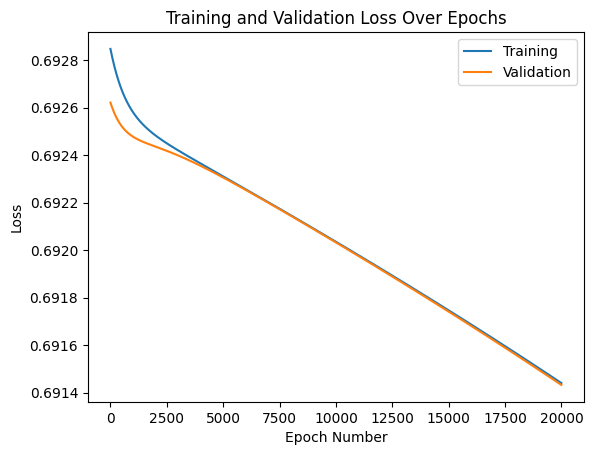

In [67]:
# Plotting
plt.plot(per_epoch_loss_train, label = 'Training')
plt.plot(per_epoch_loss_val, label = 'Validation')


plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

Report the accuracy of your classifier on your validation dataset

In [68]:
# Make predictions on the validation set using the trained model
predictions = final_classifier.predict(X_val.T)

# Convert predictions to binary labels (assuming a sigmoid activation function for binary classification)
prediction_label = (predictions > 0.5).astype(int).T

# Calculate accuracy by comparing predicted labels with ground truth labels
accuracy = accuracy_score(y_val, prediction_label)

# Print the validation accuracy as a percentage
print(f'Validation accuracy: {accuracy*100:.2f}%')

Validation accuracy: 79.94%


Explain your choice of loss function and hyperparameters:

Accuracy is approximately 80%.
For the loss function, binary cross entropy was chosen as it is typically used for binary classification, similar to what we are doing here. Multiple layers were considered, as well as different activations. Parameters were chosen such to end with 1 dimension (classification) and to optimize accuracy. Moreover, several parameters were considered in combination, as seen above, before ultimately selecting the final parameters.  